# LIBRARIES

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
pd.set_option('display.max_rows', 400) #replace n with the number of rows you want to see completely

# DATASETS

In [5]:
aCryptoCurrencies = pd.read_csv('Data\cryptocurrencies.csv')['Symbol'].values

In [6]:
aModelTypes = pd.read_csv('Data\model types.csv')['Model Type'].values

In [7]:
dfOhlc = pd.read_csv('Data\dfOhlc.csv')
dfOhlc['timestamp'] = pd.DatetimeIndex(dfOhlc['timestamp'])
dfOhlc.set_index('timestamp', inplace=True)

# Descriptive Statistics

In [8]:
dfDescriptiveStats = dfOhlc.filter(regex=':close').describe().round(2)

In [9]:
dfDescriptiveStats.columns = dfDescriptiveStats.columns.str.replace(r":close", "")

In [10]:
dfDescriptiveStats[aCryptoCurrencies]

,BCHUSD,BTCUSD,ETHUSD,LTCUSD,RPLUSD
count,6516.00,6516.00,6516.00,6516.00,6516.00
mean,481.58,49089.19,3563.92,161.14,0.93
std,132.84,8509.96,649.56,39.90,0.18
min,259.73,33098.05,2181.45,90.39,0.56
25%,355.08,42633.72,3053.48,131.84,0.78
50%,478.23,47299.22,3548.43,154.77,0.93
75%,599.14,56888.63,4096.23,187.79,1.09
max,794.64,68609.11,4845.78,288.53,1.41


# Experiments of Full Factorial Design

In [11]:

sDesignType = 'Full Factorial Design'
dfResponses = pd.DataFrame()
for sModelType in aModelTypes:
    for sSymbol in aCryptoCurrencies:
            sExperimentsFilePath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\'+ sDesignType + '\\Experiments.csv'
            dfExperiments =  pd.read_csv(sExperimentsFilePath, index_col = 'Run ID')
            dfExperiments['Model Type'] = sModelType
            dfExperiments['Exchange Rate'] = sSymbol
            dfResponses = dfResponses.append(dfExperiments)
dfResponses['Response'] = round(dfResponses['Response'],2)
dfResponses[list(dfResponses.iloc[:, -2:].columns) +list(dfResponses.iloc[:, :-2].columns)]


,Model Type,Exchange Rate,Batch Size,Number of Hidden Neurons,Response
Run ID,,,,,
0,MLP,BCHUSD,70,10,49.80
1,MLP,BCHUSD,70,10,49.64
2,MLP,BCHUSD,60,10,51.48
3,MLP,BCHUSD,70,14,55.60
4,MLP,BCHUSD,70,10,58.16
5,MLP,BCHUSD,60,14,65.69
6,MLP,BCHUSD,70,10,46.71
7,MLP,BCHUSD,60,14,51.77
8,MLP,BCHUSD,70,14,46.64


# Coefficient of Determination of 1st Order Models of 1st Order Models

In [12]:
sDesignType = 'Steepest Descent'
dfTable = pd.DataFrame(columns = aModelTypes, index  = aCryptoCurrencies)
for sModelType in aModelTypes:
    for sSymbol in aCryptoCurrencies:
        sPerformancePath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\'+ sDesignType + '\\dfPerformance.csv'
        dfPerformances =  pd.read_csv(sPerformancePath, index_col = 'Score')
        
        fRegressionScore = round(float(dfPerformances.loc['Regression Score','Value']),2)
        
        dfTable.loc[sSymbol,sModelType ] = fRegressionScore

In [13]:
dfTable

,MLP,LSTM,Conv-EncDec,Luongs-Att
BCHUSD,0.14,0.3,0.43,0.34
BTCUSD,0.04,0.07,0.14,0.02
ETHUSD,0.05,0.04,0.13,0.23
LTCUSD,0.27,0.16,0.14,0.13
RPLUSD,0.09,0.36,0.1,0.12


# Coefficient of Determination of 2nd Order Models

In [14]:
sDesignType = 'Response Surface Method'
dfTable = pd.DataFrame(columns = aModelTypes, index  = aCryptoCurrencies)
for sModelType in aModelTypes:
    for sSymbol in aCryptoCurrencies:
        sPerformancePath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\'+ sDesignType + '\\dfPerformance.csv'
        dfPerformances =  pd.read_csv(sPerformancePath, index_col = 'Performance')
        
        fRegressionScore = round(float(dfPerformances.loc['Regression Score','Value']),2)
        
        dfTable.loc[sSymbol, sModelType ] = fRegressionScore

In [15]:
dfTable

,MLP,LSTM,Conv-EncDec,Luongs-Att
BCHUSD,0.08,0.42,0.18,0.25
BTCUSD,0.36,0.77,0.29,0.4
ETHUSD,0.45,0.36,0.3,0.31
LTCUSD,0.15,0.44,0.84,0.19
RPLUSD,0.33,0.26,0.15,0.3


# Bubbe Plot of Steepest Descent Process

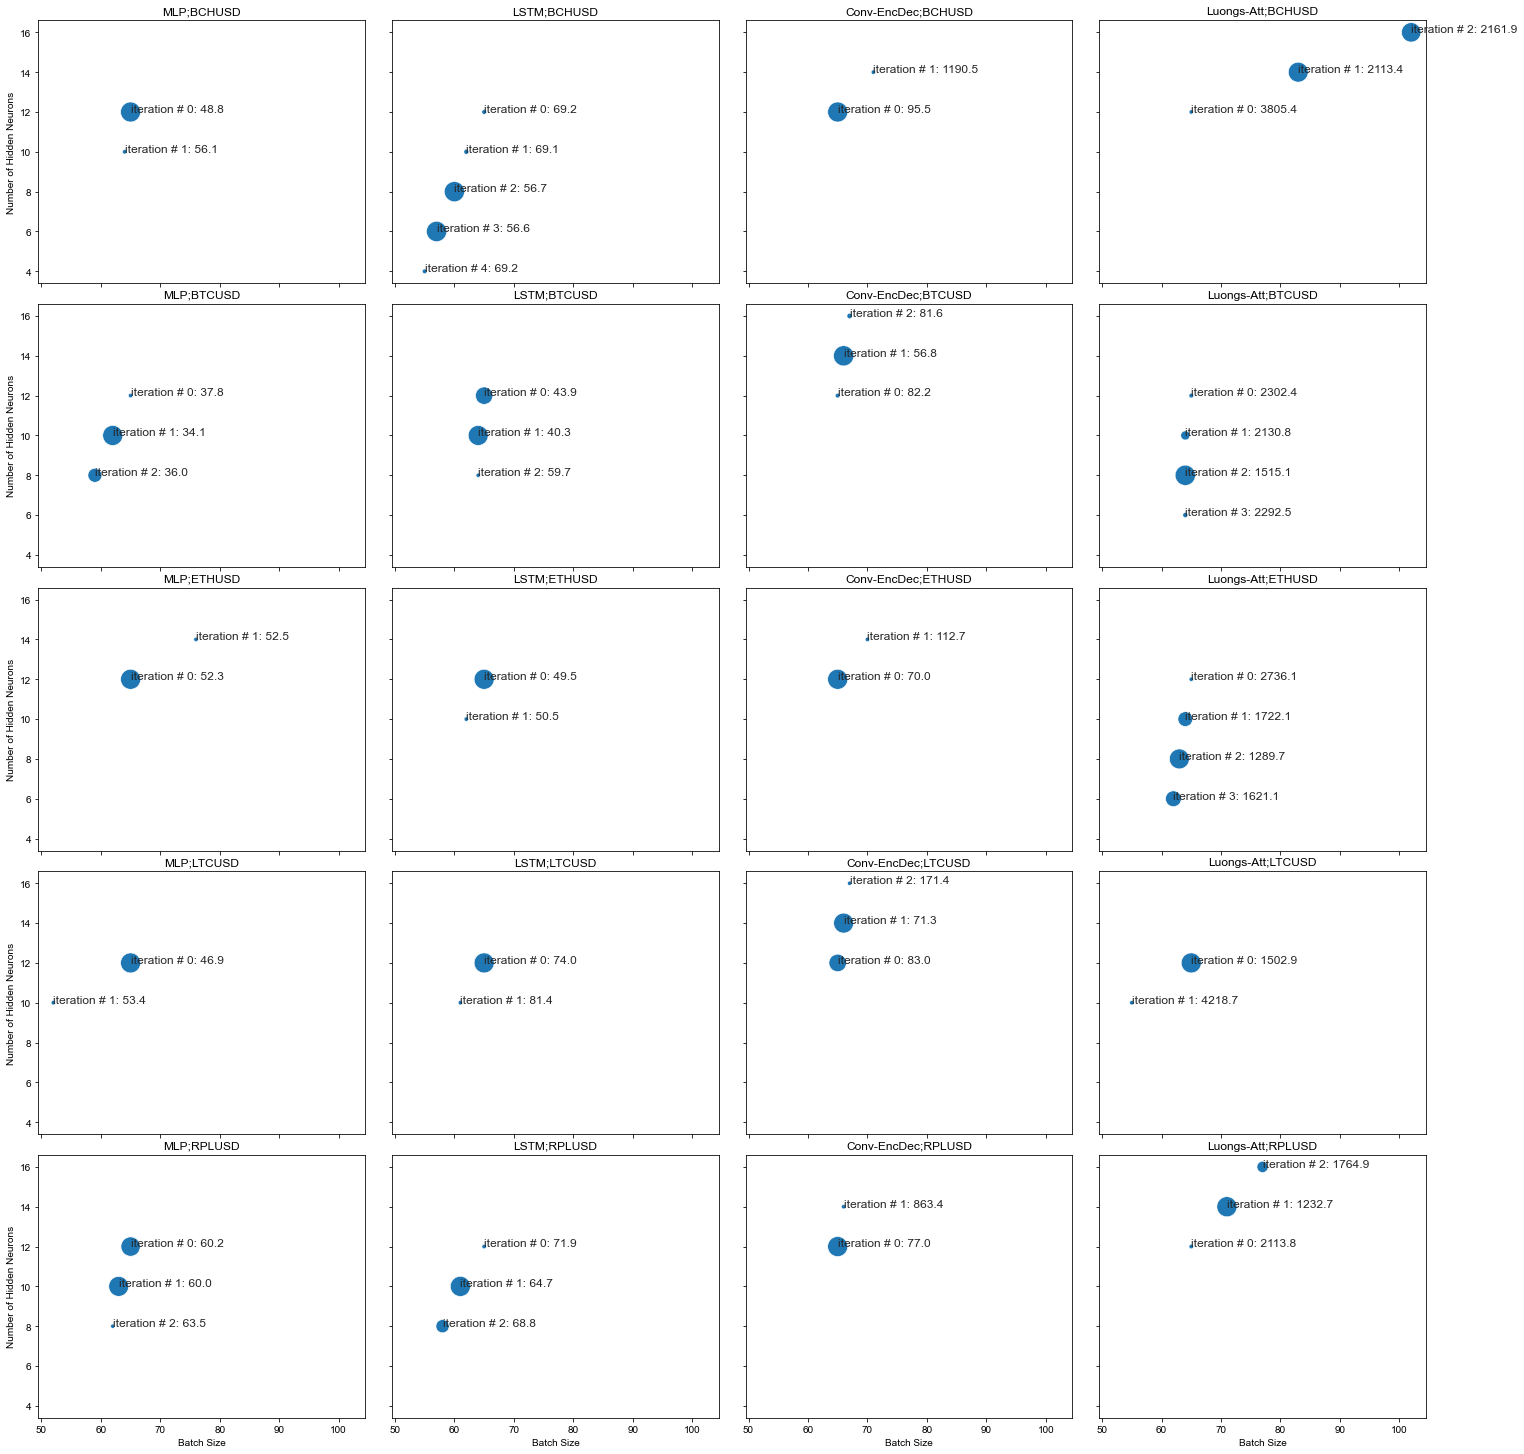

In [16]:
iNrOfCols = len(aModelTypes) 
iNrOfRows = len(aCryptoCurrencies)
oFig, aAxises = plt.subplots(iNrOfRows, iNrOfCols, figsize=(20,20),sharex = True, sharey = True)
oFig.tight_layout()

j = 0
for sSymbol in aCryptoCurrencies:
    for sModelType in aModelTypes:
        sExperimentsPath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\Steepest Descent\\Experiments.csv'
        dfExperiments =  pd.read_csv(sExperimentsPath, index_col = 'Run ID')

        dfExperiments['Response'] =round(dfExperiments['Response'], 1)
        dfExperiments['Inverse_Response'] = 1/dfExperiments['Response']

        iSampleGraphRow =  int(j/iNrOfCols)
        iSampleGraphCol = int(j%iNrOfCols)

        sns.set(rc = {'figure.figsize':(20,8)})
        sns.set_style('white')
        oLinePlot = sns.scatterplot(data = dfExperiments, 
                     x = 'Batch Size', 
                     y = 'Number of Hidden Neurons', 
                    size = 'Inverse_Response',
                                    sizes=(20, 400),
                                    legend = False,
                    ax =aAxises[iSampleGraphRow,iSampleGraphCol])

        oLinePlot.set_title(sModelType + ';' + sSymbol )


        for i in range(0, dfExperiments.shape[0]):
            iRunId = dfExperiments.iloc[i].name
            iX = dfExperiments.iloc[i].loc['Batch Size']
            iY = dfExperiments.iloc[i].loc['Number of Hidden Neurons']
            fResponse =round(dfExperiments.iloc[i].loc['Response'],1)
            sTextToAnnotate =  'iteration # '+ str(iRunId) + ': ' + str(fResponse)
            oLinePlot.annotate(xy = (iX,iY), text=sTextToAnnotate)


        j = j + 1

# Surface Plot of Grid Search

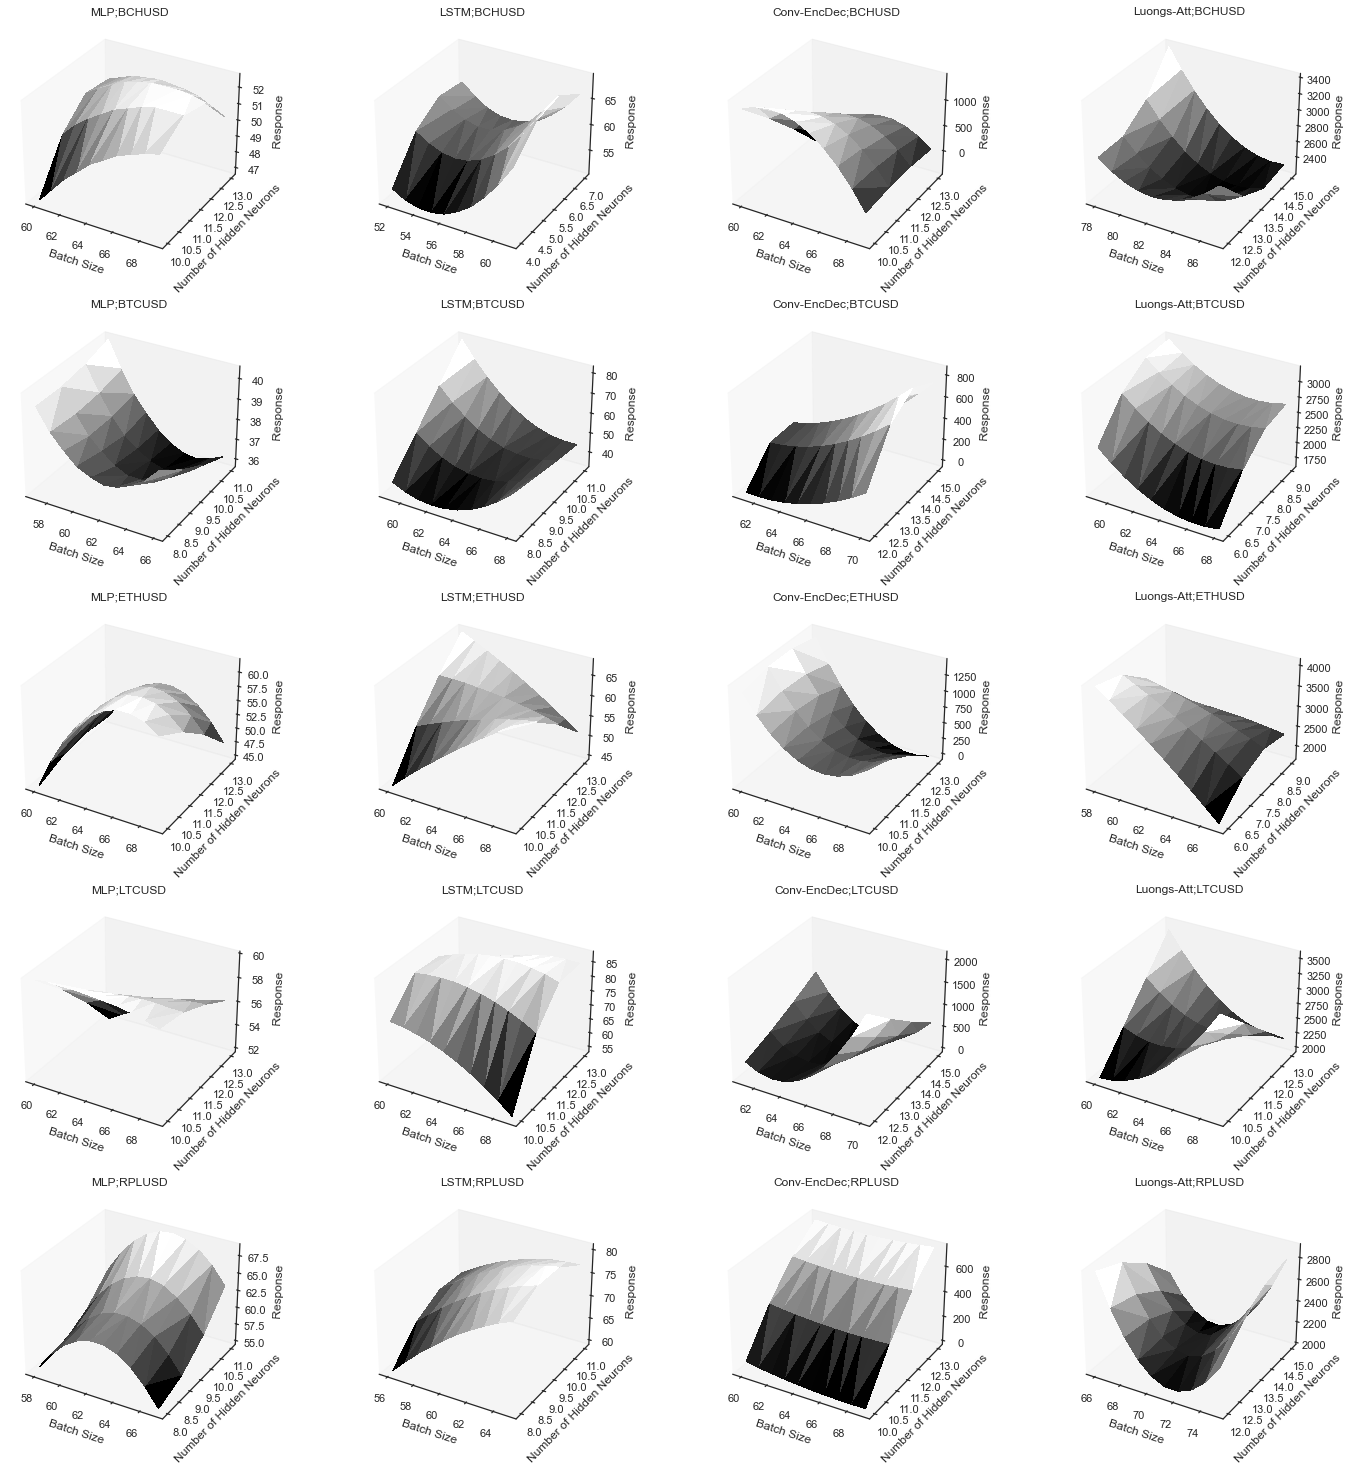

In [17]:
iNrOfCols = len(aModelTypes) 
iNrOfRows = len(aCryptoCurrencies)
oFig, aAxises = plt.subplots(iNrOfRows, iNrOfCols, figsize=(20,20),subplot_kw=dict(projection='3d')) #sharex = True, sharey = True 
oFig.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.2)
j = 0
for sSymbol in aCryptoCurrencies:
    for sModelType in aModelTypes:
        sExperimentsPath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\Response Surface Method\\Grid Search.csv'
        dfGridResearch =  pd.read_csv(sExperimentsPath, index_col = 'Run ID')

        dfGridResearch['Response'] =round(dfGridResearch['Response'], 1)
        dfGridResearch['Inverse_Response'] = 1/dfGridResearch['Response']

        iSampleGraphRow =  int(j/iNrOfCols)
        iSampleGraphCol = int(j%iNrOfCols)
        
        sns.set(rc = {'figure.figsize':(20,8)})
        sns.set_style('white')
        
        
        X = dfGridResearch.iloc[:, 0]
        Y = dfGridResearch.iloc[:, 1]
        Z =dfGridResearch['Response'] 
        
        aAxises[iSampleGraphRow, iSampleGraphCol].plot_trisurf(
            X, 
            Y, 
            Z, 
            linewidth=0, 
            antialiased=False,
            cmap='gist_gray'
        )
        
        aAxises[iSampleGraphRow, iSampleGraphCol].set_xlabel(X.name)
        aAxises[iSampleGraphRow, iSampleGraphCol].set_ylabel(Y.name)
        aAxises[iSampleGraphRow, iSampleGraphCol].set_zlabel(Z.name)
        aAxises[iSampleGraphRow, iSampleGraphCol].grid(False)
        
        aAxises[iSampleGraphRow, iSampleGraphCol].set_title(sModelType + ';' + sSymbol )

        j = j + 1

# Experiments of Central Composite Design

In [18]:
sDesignType = 'Central Composite Design'
dfResponses = pd.DataFrame()
for sModelType in aModelTypes:
    for sSymbol in aCryptoCurrencies:
            sExperimentsFilePath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\'+ sDesignType + '\\Experiments.csv'
            dfExperiments =  pd.read_csv(sExperimentsFilePath, index_col = 'Run ID')
            dfExperiments['Model Type'] = sModelType
            dfExperiments['Exchange Rate'] = sSymbol
            dfResponses = dfResponses.append(dfExperiments)
dfResponses['Response'] = round(dfResponses['Response'],2)

dfResponses[list(dfResponses.iloc[:, -2:].columns) +list(dfResponses.iloc[:, :-2].columns)]

,Model Type,Exchange Rate,Batch Size,Number of Hidden Neurons,Response
Run ID,,,,,
0,MLP,BCHUSD,61,10,46.88
1,MLP,BCHUSD,68,10,53.02
2,MLP,BCHUSD,61,13,49.97
3,MLP,BCHUSD,68,13,54.42
4,MLP,BCHUSD,65,12,50.97
5,MLP,BCHUSD,65,12,69.18
6,MLP,BCHUSD,65,12,49.30
7,MLP,BCHUSD,65,12,53.57
8,MLP,BCHUSD,60,12,52.80


# Optimum Configurations via RSM

In [19]:
dfTable = pd.DataFrame(columns = aModelTypes, index  = aCryptoCurrencies)
for sModelType in aModelTypes:
    for sSymbol in aCryptoCurrencies:
        sPerformancePath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\Response Surface Method\\dfPerformance.csv'
        dfPerformances =  pd.read_csv(sPerformancePath, index_col = 'Performance')
        
        aHyperparameterNames = dfPerformances.loc['Hyperparameter Names','Value']
        aOptimumHyperparameters = dfPerformances.loc['Optimum Hyperparameters','Value'].replace('.0', '')
        
        dfTable.loc[sSymbol, sModelType] = aOptimumHyperparameters

In [20]:
dfTable

,MLP,LSTM,Conv-EncDec,Luongs-Att
BCHUSD,"[60, 10]","[55, 4]","[60, 13]","[85, 14]"
BTCUSD,"[64, 11]","[62, 8]","[62, 12]","[66, 6]"
ETHUSD,"[60, 10]","[60, 10]","[68, 13]","[67, 6]"
LTCUSD,"[60, 13]","[69, 10]","[66, 15]","[60, 10]"
RPLUSD,"[67, 8]","[56, 8]","[68, 10]","[70, 15]"


# Test Results of Optimum Configurations via RSM

In [23]:
import os

In [78]:
dfTable = pd.DataFrame(columns = aModelTypes, index  = aCryptoCurrencies)
for sModelType in aModelTypes:
    for sSymbol in aCryptoCurrencies:
        sExperimentsPath = 'Data\\' + sSymbol +'\\'+ sModelType + '\\Optimum Design\\Experiments.csv'
        
        dfExperiments =  pd.read_csv(sExperimentsPath, index_col = 'Run ID')

        dfTable.loc[sSymbol, sModelType] = dfExperiments.loc[0, 'Response']

In [79]:
dfTable

,MLP,LSTM,Conv-EncDec,Luongs-Att
BCHUSD,47.825834,55.075167,68.721883,80.61469
BTCUSD,36.158233,46.668726,43.685923,1838.94727
ETHUSD,51.776433,52.527063,51.703628,71.787779
LTCUSD,52.566987,61.888913,110.833586,127.491509
RPLUSD,69.440883,68.174606,71.67011,89.41441


# Simulation

In [63]:
import tensorflow as tf

In [85]:
def fCalculateLoss(aActual, aPrediction):
    aLossDueToError = tf.math.subtract(aActual ,aPrediction)
    aLossDueToError = tf.math.abs(aLossDueToError)

    fPenalty = tf.math.reduce_max(aLossDueToError)

    aLossDueToSignDiff = tf.math.abs(tf.math.subtract(tf.math.sign(aActual), tf.math.sign(aPrediction)) )
    aLossDueToSignDiff = tf.where(aLossDueToSignDiff == 0, aLossDueToSignDiff, fPenalty)

    aTotalLoss = aLossDueToError + aLossDueToSignDiff

    return tf.math.reduce_mean(aTotalLoss)

sModelType = 'MLP'
sOutputSymbol = 'BCHUSD'

sOptimumModelPath =  'Data/'+ sOutputSymbol +'//'+ sModelType + '//Optimum Design//0//'

oOptimumModel = tf.keras.models.load_model(sOptimumModelPath+  '__model__', custom_objects={'fCalculateLoss': fCalculateLoss})
oOptimumModel
